In [1]:
# https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/
# pip install -r requirements.txt

C:\Users\ksbso\AppData\Local\Temp\ipykernel_52248\804796906.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
import pandas as pd
import plotly.express as px
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import torch
from torch import nn

# set plotly parameters
import plotly.io as pio
pio.renderers.default='notebook'

In [48]:
def split_sequences(input, output, steps_in, steps_out):
    X, y = list(), list()
    for i in range(len(input)):
        end_i = i + steps_in
        out_end = end_i + steps_out - 1

        if out_end > len(input):
            break

        seq_x = input[i:end_i]
        seq_y = output[end_i-1: out_end, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

((237, 10, 4), (237, 5))

In [50]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [51]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [52]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = forecast # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

c:\Users\ksbso\Programming Projects\python-ml\.venv\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



In [53]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.44512, test loss: 0.61378
Epoch: 100, train loss: 0.02053, test loss: 0.00920
Epoch: 200, train loss: 0.00789, test loss: 0.00681
Epoch: 300, train loss: 0.00500, test loss: 0.00739
Epoch: 400, train loss: 0.00437, test loss: 0.00706
Epoch: 500, train loss: 0.00401, test loss: 0.00688
Epoch: 600, train loss: 0.00381, test loss: 0.00667
Epoch: 700, train loss: 0.00364, test loss: 0.00644
Epoch: 800, train loss: 0.00353, test loss: 0.00627
Epoch: 900, train loss: 0.00346, test loss: 0.00606


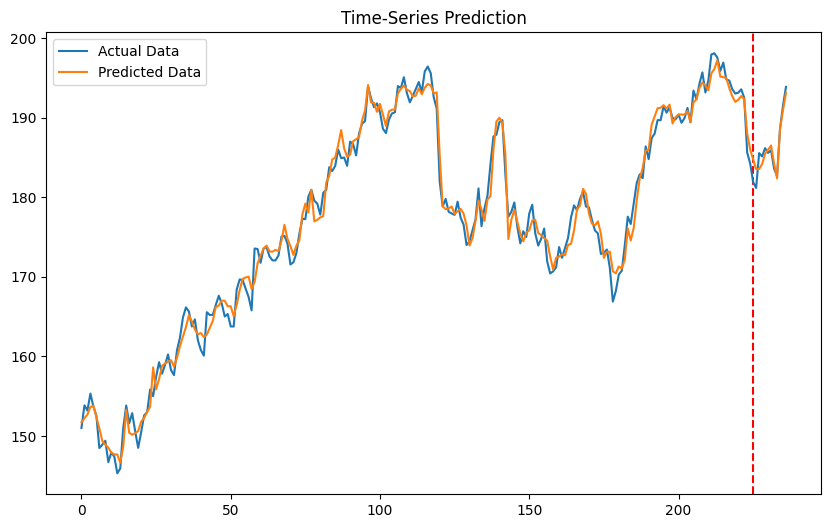

In [54]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 10, forecast)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 10, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

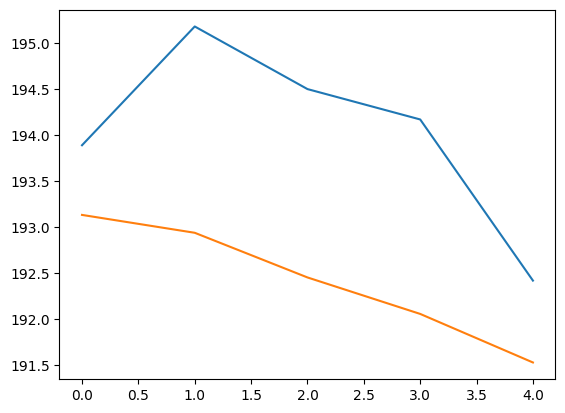

In [55]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.show()

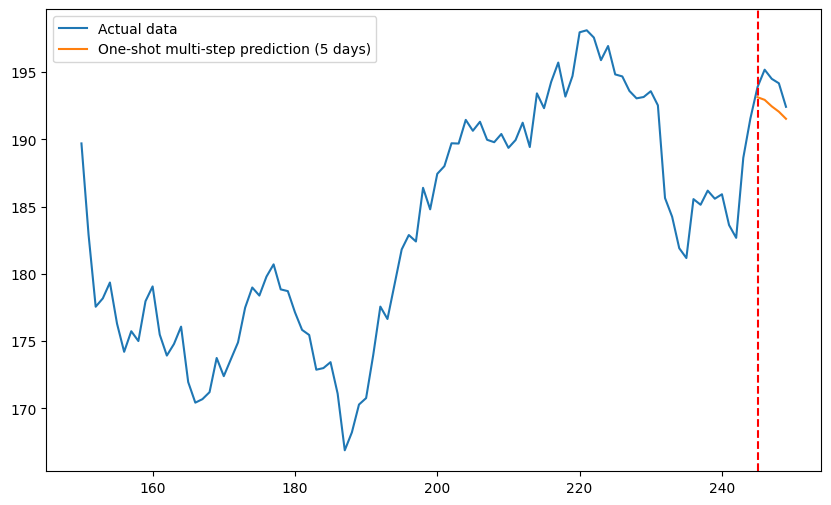

In [62]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(150, len(y))]
plt.plot(a, y[150:], label='Actual data');
c = [x for x in range(len(y)-forecast, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (5 days)')
plt.axvline(x=len(y)-forecast, c='r', linestyle='--')
plt.legend()
plt.show()